# Morphing water vapor from SAPHIR
### Erfan Jahangir and Brian Mapes May 2018

#### Matlab codes have been used to create a set of hourly "synths" analyzed in this 1-day test
#### These arrays are [241, 721) values of RH for now, on a half degree grid 30S-30N


---------


In [73]:
!ls Synths/*20120701T08*mat

Synths/2012-07-01T02-44-02forward20120701T080000.mat
Synths/2012-07-01T04-33-15forward20120701T080000.mat
Synths/2012-07-01T06-23-14forward20120701T080000.mat
Synths/2012-07-01T08-14-54backward20120701T080000.mat
Synths/2012-07-01T09-25-27backward20120701T080000.mat
Synths/2012-07-01T11-14-57backward20120701T080000.mat


#### General strategy of this notebook

Like any programming job, we work backward from a result-shaped container, and forward from the most precious original data input whose value we are trying to optimize. These intentions make it natural to build the middle steps and grab auxiliary inputs, as necessary to achieve success. Initially we achieve success in the simplest way, then later add sophistication -- but only to the extent it improves signal and reduces noise, as seen in the initial success of the data products. 

In this case, the results-shaped container is a single 1/2-degree (for now) array of 

1. **WV** (water vapor)
1. **AT** (the 'analysis tendency' of the morphing operation, representing all the physical source-sink terms). 
1. **t_early** (the time of the earlier observation that made the above products)
1. **t_late** (the time of the later observation " " " )

In this case, the precious data is swaths of data, made up of pixels, of WV500 retrieved from SAPHIR channels by Helene Brignietz and colleagues. These input data include arrays of: 

* the WV **value** at each pixel
* the **latitude** " " " 
* the **longitude** " " " 
* the **time of observation** " " " 

----------

In [74]:
import numpy as np 
import glob             # to list available files
import scipy.io as spio # to read the .mat files

## Step 1: Create the results-shaped containers  

In [75]:
DX = 0.5 # degrees
SOUTH = -60 # Central latitudes of southern grid  cells
NORTH = 60  # " " northern " " 
WEST = 0 # Central longitude of westernmost cell
EAST = 360 # " " easternmost " 

# Build 1D spatial coordinate arrays 
NLAT = int( (NORTH-SOUTH)/DX +1)
lat = np.linspace(SOUTH, NORTH, NLAT)

NLON = int( (EAST-WEST)/DX +1)
lon = np.linspace(WEST, EAST, NLON)


# Now build containers for the results we desire
# Which order? LON,LAT? or LAT,LON? The one the Matlab creates

WV = np.zeros( (NLAT,NLON) )
AT = np.zeros( (NLAT,NLON) )

### Step 2: The things we need to fill the containers

To fill the above arrays, we will use the *time-proximity-weighted average* for WV500:  

$ WV500 = ( WV_{before}*dt_{after} + WV_{before}*dt_{after} )/(dt_{before} + dt_{after}) $ 

and the simplest *estimate of the time derivative* using the before and after observations:

$ AT500 = ( WV_{after} - WV_{before})/(dt_{before} + dt_{after}) $ 

**Thus, we need $ WV_{before}, WV_{after}, dt_{before}, dt_{after}  $**

----------------

In [76]:
# Containers for the necessary quantities to get our final products

WV_before = np.zeros( (NLAT,NLON) )
WV_after  = np.zeros( (NLAT,NLON) )
dt_before = np.zeros( (NLAT,NLON) )
dt_after  = np.zeros( (NLAT,NLON) )

## Now, how to get $ WV_{before}, WV_{after}, dt_{before}, dt_{after} $ ? 

#### We need two _time stacks_ of product-shaped lat-lon arrays. 

Two, because we need the VALUE and the TIME of each observation we put into the stack. 

These stack is a 3D array, centered on the product time (dt=0). It doesn't matter how long in time  this stack extends, as long as it is long enough that **every pixel in space has a before and an after observation**. That is, the DTMAX just has to be at least as big as the longest time gap between observations. Also, the time step between the layers in the stack just has to be short enough that we aren't wasting observations by over-writing some locations with multiple observations. Since the orbit time is about 100 minutes, 1 hour stacks are safe. 

Initially, let's make a container full of zeros. 

In [77]:
DTMAX = 6    # hours. The size of the centered stack will then be 2*DTMAX+1. 

WV_stack =  np.zeros( (NLAT,NLON, 2*DTMAX+1) )
tobs_stack = np.zeros( (NLAT,NLON, 2*DTMAX+1) )

In [78]:
whos

Variable     Type          Data/Info
------------------------------------
AT           ndarray       241x721: 173761 elems, type `float64`, 1390088 bytes (1.3256912231445312 Mb)
DTMAX        int           6
DTstack      int           1
DX           float         0.5
EAST         int           360
NLAT         int           241
NLON         int           721
NORTH        int           60
SOUTH        int           -60
WEST         int           0
WV           ndarray       241x721: 173761 elems, type `float64`, 1390088 bytes (1.3256912231445312 Mb)
WV_after     ndarray       241x721: 173761 elems, type `float64`, 1390088 bytes (1.3256912231445312 Mb)
WV_before    ndarray       241x721: 173761 elems, type `float64`, 1390088 bytes (1.3256912231445312 Mb)
WV_stack     ndarray       241x721x13: 2258893 elems, type `float64`, 18071144 bytes (17.233985900878906 Mb)
dt_after     ndarray       241x721: 173761 elems, type `float64`, 1390088 bytes (1.3256912231445312 Mb)
dt_before    ndarray     

# Now the real data work is clear.

1. **How do we interrogate the stack** to get $ WV_{before}, WV_{after}, dt_{before}, dt_{after} $? 
    * For each location (lat,lon), the stack is a time series of length 2\*DTMAX+1. 
    * Need a method to find nonzero values closest to dt=0 (the center of the series). 
    * Special case: when there is an observation in dt=0, that is WV -- but what is AT?
1. **How do we fill the stack initially**, from the set of observation pixels within DTMAX of the time of the product? 
    * Loop over all the pixels in the input data within +/- DTMAX of the product hour. 
        * Each pixel has these values: {WVobs, tobs, latobs, lonobs}.
    * Place the pixel in the dt=0 layer of WV_stack and tobs_stack, at location (latobs, lonobs)
    * Place the pixel in the dt=1 layer at (latobs +v\*DT_stack\*1, lonobs +u\*DT_stack\*1)
        * this requires obtaining wind data u,v for that location (reanalysis u500,v500)
    * etc. for other dt layers in the stack
1. **How do we repeat the process for the next product hour?** 
    * We could start the whole process over from np.zeros(). Inefficient but safe. 
    * Better from efficieny perspective is to 
        * np.roll(WV_stack), np.roll(tobs_stack) to recenter the stack on the next hour.
        * WV_stack[:,:,DTMAX\*2]=0  to clobber where the periodic roll() operation has shifted past data into the future
        * Now just fill that future stack time, WV_stack[:,:,DTMAX\*2], with real data
            * this involves querying the satellite data up to DTMAX hours ahead of that time, shifting it all backward in time
            * (latobs -v\*DT_stack\*DTMAX, latobs -u\*DT_stack\*DTMAX)
            * (latobs -v\*DT_stack\*(DTMAX-1), latobs -u\*DT_stack\*(DTMAX-1))
            * etc. 

# First time: fill the stack for a given time

In [96]:
tnow = 8  # well away from the ends of the data available
listfiles = 'Synths/*20120701T' + str(tnow).zfill(2) +'*mat'
listfiles

'Synths/*20120701T08*mat'

In [98]:
!ls Synths/*20120701T08*mat

Synths/2012-07-01T02-44-02forward20120701T080000.mat
Synths/2012-07-01T04-33-15forward20120701T080000.mat
Synths/2012-07-01T06-23-14forward20120701T080000.mat
Synths/2012-07-01T08-14-54backward20120701T080000.mat
Synths/2012-07-01T09-25-27backward20120701T080000.mat
Synths/2012-07-01T11-14-57backward20120701T080000.mat


In [106]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/bem/miniconda3/envs/MPO624/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mat']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


synth.synthTime 15522.333333333332
tDisp_hrs 4.406247573919245


/Users/bem/miniconda3/envs/MPO624/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


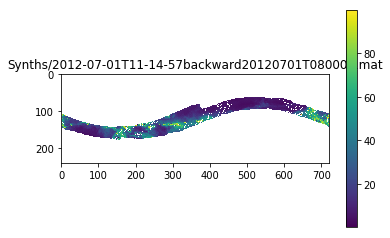

In [125]:
filename = 'Synths/2012-07-01T11-14-57backward20120701T080000.mat'
#'Synths/2012-07-01T02-44-02forward20120701T080000.mat'

mat = spio.loadmat(filename, squeeze_me=True, struct_as_record=False)
synth = mat['synth']    
data = synth.gridded
data [data < 0] = np.nan # get rid of the -9899 values in the data 

print('synth.synthTime', synth.synthTime)
print('tDisp_hrs', synth.tDisp_hrs)
imshow(data); title(filename); colorbar()

In [134]:
size(glob.glob(listfiles))

6

In [144]:
WV_stack =  np.zeros( (NLAT,NLON, size(glob.glob(listfiles))) )
tobs_stack= np.zeros( (NLAT,NLON, size(glob.glob(listfiles))) )

for idx,filename in enumerate(glob.iglob(listfiles), start=0):
    print('%s' % filename)
    mat = spio.loadmat(filename, squeeze_me=True, struct_as_record=False)
    synth = mat['synth']
    data = synth.gridded
    data [data < 0] = np.nan
    print('synth.synthTime', synth.synthTime)
    print('tDisp_hrs', synth.tDisp_hrs)
    
    WV_stack  [:,:,idx] = data 
    tobs_stack[:,:,idx] = synth.tDisp_hrs + data*0 # this propagates the nan mask to missing areas 

Synths/2012-07-01T02-44-02forward20120701T080000.mat
synth.synthTime 15522.333333333332
tDisp_hrs -4.3162907176301815
Synths/2012-07-01T04-33-15forward20120701T080000.mat
synth.synthTime 15522.333333333332
tDisp_hrs -2.4899183198431274
Synths/2012-07-01T06-23-14forward20120701T080000.mat
synth.synthTime 15522.333333333332
tDisp_hrs -0.6455710948939668
Synths/2012-07-01T08-14-54backward20120701T080000.mat
synth.synthTime 15522.333333333332
tDisp_hrs 0.8734107176132966
Synths/2012-07-01T09-25-27backward20120701T080000.mat
synth.synthTime 15522.333333333332
tDisp_hrs 2.373961858349503
Synths/2012-07-01T11-14-57backward20120701T080000.mat
synth.synthTime 15522.333333333332
tDisp_hrs 4.406247573919245


/Users/bem/miniconda3/envs/MPO624/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


/Users/bem/miniconda3/envs/MPO624/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


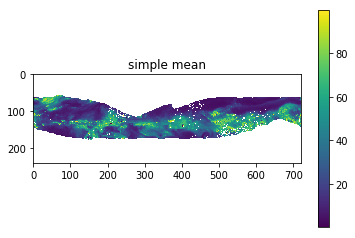

In [148]:
imshow(np.nanmean(WV_stack, axis=2)); title('simple mean'); colorbar()

/Users/bem/miniconda3/envs/MPO624/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


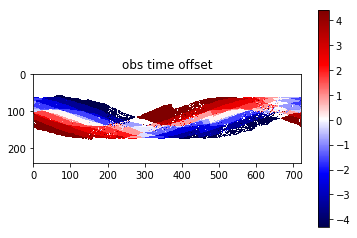

In [163]:
imshow(np.nanmean(tobs_stack, axis=2), cmap='seismic'); title('obs time offset'); colorbar()

/Users/bem/miniconda3/envs/MPO624/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


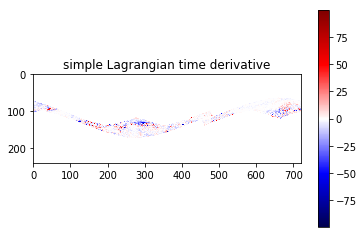

In [162]:
diffs = np.nanmean(WV_stack[:,:,3:], axis=2) - np.nanmean(WV_stack[:,:,0:3], axis=2)
imshow(diffs, cmap='seismic'); title('simple Lagrangian time derivative'); colorbar()